In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'auctions.game' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'auctions.experiment' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'auctions.equilibriumsolverrun' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.regis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [38]:
# load runs from experiments
experiments = [
    # 'jan18_cfr_v2'
    'jan12_long_v2'
]

runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 16 runs


# Analyze runs

In [39]:
records = []
for run in tqdm(runs):    
    game = run.game.load_as_spiel()
    record = {
        'run_name': run.name,
        'game_name': run.game.name, 
        'seed': run.config.get('seed'), 
        'config': run.get_config_name(),
        'alg': get_algorithm_from_run(run),
    }
    
    record.update(get_game_info(game, run.game))  
    
    record['no_error'] = False
    records.append(record) # Put it here so you see the False's in the display
        
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=True)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue
    
    try:
        
        record['t'] = final_checkpoint.t
        record['walltime'] = run.walltime(),
        evaluation = final_checkpoint.get_modal_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan

            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        record.update(**analyze_samples(evaluation.samples, game))

        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
        
        
        ### What is the NC of the original game?
        game2 = run.game.load_as_spiel()
        game2.auction_params.sor_bid_bonus_rho = 0
        env_and_policy = make_env_and_policy(game2, dict(final_checkpoint.equilibrium_solver_run.config))
        for agent in env_and_policy.agents:
            agent.policy = policy
        for player in range(game.num_players()):
            env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        modal_policy = env_and_policy.make_policy()
        worked, time_taken, modal_retval = time_bounded_run(300, nash_conv, game2, modal_policy, return_only_nash_conv=True, restrict_to_heuristics=False)
        print(f"With bonus: {nc}\n With no bonus: {modal_retval}")

        if not worked:
            print("Aborted run because time")
            record['true_nc'] = None
        else:
            record['true_nc'] = modal_retval
        
        record['no_error'] = True
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

  6%|██████████████▋                                                                                                                                                                                                                           | 1/16 [00:01<00:27,  1.86s/it]

With bonus: 0.0
 With no bonus: 0.11337037037037234


 12%|█████████████████████████████▎                                                                                                                                                                                                            | 2/16 [00:04<00:34,  2.49s/it]

With bonus: 0.0
 With no bonus: 0.0


 19%|███████████████████████████████████████████▉                                                                                                                                                                                              | 3/16 [00:05<00:24,  1.86s/it]

With bonus: 0.0
 With no bonus: 0.0


 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 4/16 [00:07<00:20,  1.68s/it]

With bonus: 0.0
 With no bonus: 0.0


 31%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 5/16 [00:09<00:21,  1.94s/it]

With bonus: 0.0
 With no bonus: 0.0


 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 6/16 [00:11<00:17,  1.75s/it]

With bonus: 0.0
 With no bonus: 0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7/16 [00:12<00:16,  1.78s/it]

With bonus: 0.0
 With no bonus: 0.0


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/16 [00:15<00:16,  2.10s/it]

With bonus: 0.0
 With no bonus: 0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9/16 [00:17<00:14,  2.03s/it]

With bonus: 0.143136953111636
 With no bonus: 0.1401902204545138


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10/16 [00:19<00:11,  1.98s/it]

With bonus: 0.0
 With no bonus: 0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11/16 [00:22<00:11,  2.33s/it]

With bonus: 0.0
 With no bonus: 0.0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12/16 [00:24<00:09,  2.28s/it]

With bonus: 0.0
 With no bonus: 0.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 13/16 [00:25<00:05,  1.95s/it]

With bonus: 0.0
 With no bonus: 0.0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 14/16 [00:28<00:04,  2.07s/it]

With bonus: 0.0
 With no bonus: 0.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 15/16 [00:29<00:01,  1.83s/it]

With bonus: 0.0
 With no bonus: 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:30<00:00,  1.93s/it]

With bonus: 0.0
 With no bonus: 0.0
16


In [8]:
df = pd.DataFrame.from_records(records)
with pd.option_context('display.max_rows', None):
    display(df[['value_structure', 'rule', 'base_game_name', 'deviations', 'no_error']].value_counts().sort_index())

value_structure  rule       base_game_name  deviations  no_error
quasi_linear     base       jan12_0_base    1000        True        1
                            jan12_1_base    1000        True        1
                            jan12_2_base    1000        True        1
                            jan12_3_base    1000        True        1
                            jan12_4_base    1000        True        1
                 tie_break  jan12_0_base    1000        True        1
                            jan12_1_base    1000        True        1
                            jan12_2_base    1000        True        1
                            jan12_3_base    1000        True        1
                            jan12_4_base    1000        True        1
Name: count, dtype: int64

0


Series([], Name: count, dtype: int64)

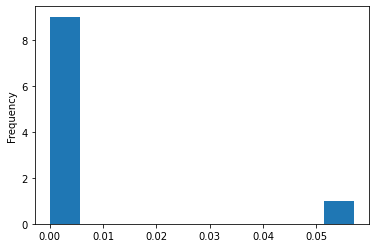

In [9]:
df['heuristic_conv'].plot(kind='hist')
print(df['heuristic_conv'].isnull().sum())

df.query('heuristic_conv.isnull()')[['value_structure', 'rule', 'base_game_name', 'deviations', 'no_error']].value_counts().sort_index()
# Huh???? Why are 0 deviation games showing as null. Is that for real?

0


Series([], Name: count, dtype: int64)

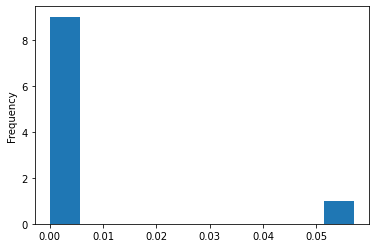

In [10]:
df['nash_conv'].plot(kind='hist')
print(df['nash_conv'].isnull().sum())

df.query('nash_conv.isnull()')[['value_structure', 'rule', 'base_game_name', 'deviations', 'no_error']].value_counts().sort_index()
# Huh???? Why are 0 deviation games showing as null. Is that for real?

deviations  value_structure
1000        quasi_linear       AxesSubplot(0.125,0.125;0.775x0.755)
Name: auction_lengths, dtype: object

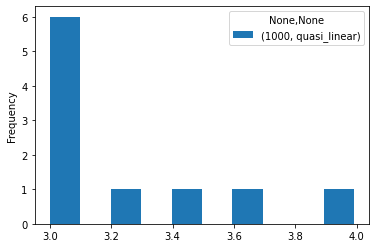

In [11]:
df.groupby(['deviations', 'value_structure'])['auction_lengths'].plot(kind='hist', legend=True)

In [12]:
palette = dict()
colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']
# for i, v in enumerate(df['variant'].unique()):
#     palette[v] = colors[i]

In [13]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [14]:
### Remove bad entries

# TODO: generalize to 3+ players

good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}').copy()
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)

#### So many removed... wow


(10, 10)

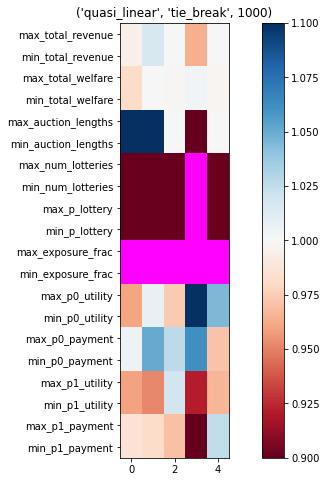

In [15]:


# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths', 'num_lotteries', 'p_lottery', 'exposure_frac']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule', 'deviations']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule', 'deviations']):
    if idx[1] == 'base':
        continue
        
    try:
        data_grp_df = make_data_dict(grp_df)
        normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
        data_normalized_df = make_data_dict(normalizer_grp_df)

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.9, vcenter=1, vmax=1.1)
        cmap = plt.cm.get_cmap('RdBu').copy()
        cmap.set_bad('magenta')
        plt.figure(figsize=(12, 8))
        data = (data_grp_df / data_normalized_df).values.T
        plt.imshow(data, cmap=cmap, norm=cmap_norm)
        plt.title(idx)
        plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
        plt.colorbar()
        plt.show()
    except Exception as e:
        print(idx, e)

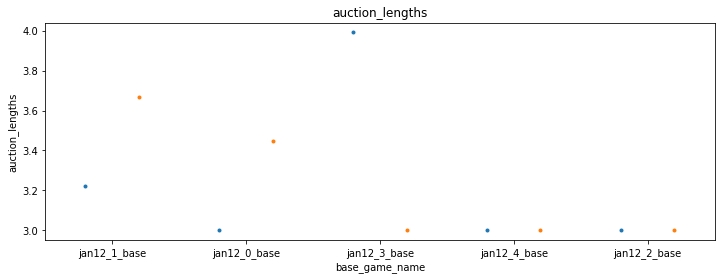

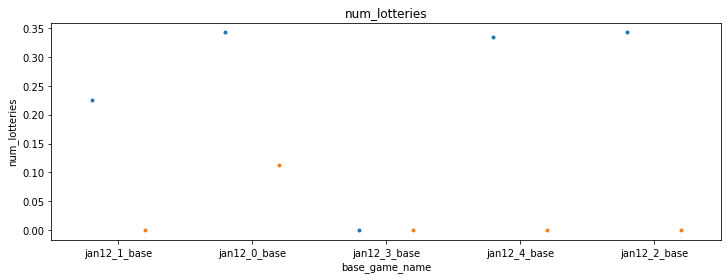

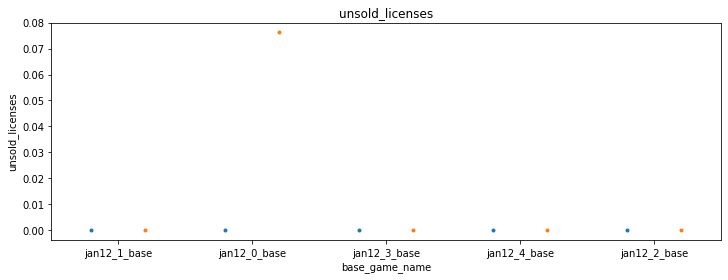

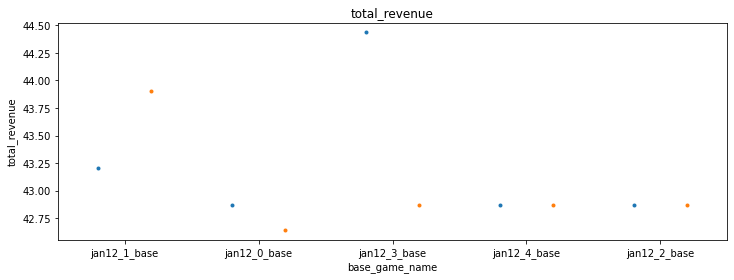

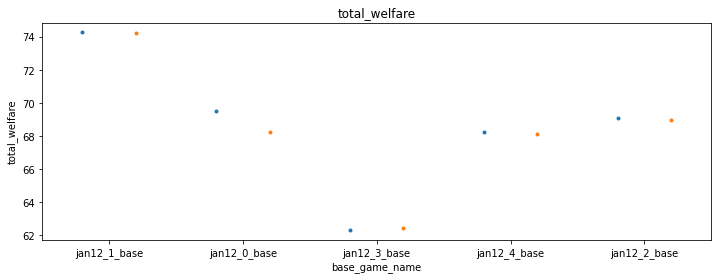

In [16]:
for metric_name in ['auction_lengths', 'num_lotteries', 'unsold_licenses', 'total_revenue', 'total_welfare']:
    plt.figure(figsize=(12, 4))
    sns.swarmplot(data=df, x='base_game_name', y=metric_name, hue='tiebreaking_policy', dodge=True, size=4)
    plt.gca(); plt.legend([], [], frameon=False)
    plt.title(metric_name)
    plt.show()